In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
prov_filer = "LANAO DEL SUR"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)
brgys_geodata = brgys_geodata.to_crs("EPSG:4326")

prov_cond = brgys_geodata["Pro_Name"].str.contains(prov_filer)
brgys_geodata = brgys_geodata[prov_cond]
print("brgys_geodata",brgys_geodata.shape)

roads_intersects = pd.read_csv(OUTPUT_PATH+'RoadsARMM_OSM2019_Intersects_Clean.csv')
roads_intersects["osm_id"] = roads_intersects["osm_id"].astype(str)

roads_geodata = gpd.read_file(OUTPUT_PATH+'RoadsARMM_OSM2019_Geodata_Clean/RoadsARMM_OSM2019_Geodata_Clean.shp')
roads_geodata = roads_geodata.merge(roads_intersects,on="osm_id",how="left")
prov_cond = roads_geodata["PROV_LIST"].str.contains(prov_filer)
roads_geodata = roads_geodata[prov_cond]
print("roads_geodata",roads_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond]
prov_cond = schools_geodata["PROV"].str.contains(prov_filer)
schools_geodata = schools_geodata[prov_cond]
print("schools_geodata",schools_geodata.shape)

brgys_geodata (1159, 9)
roads_geodata (202, 7)
schools_geodata (891, 13)


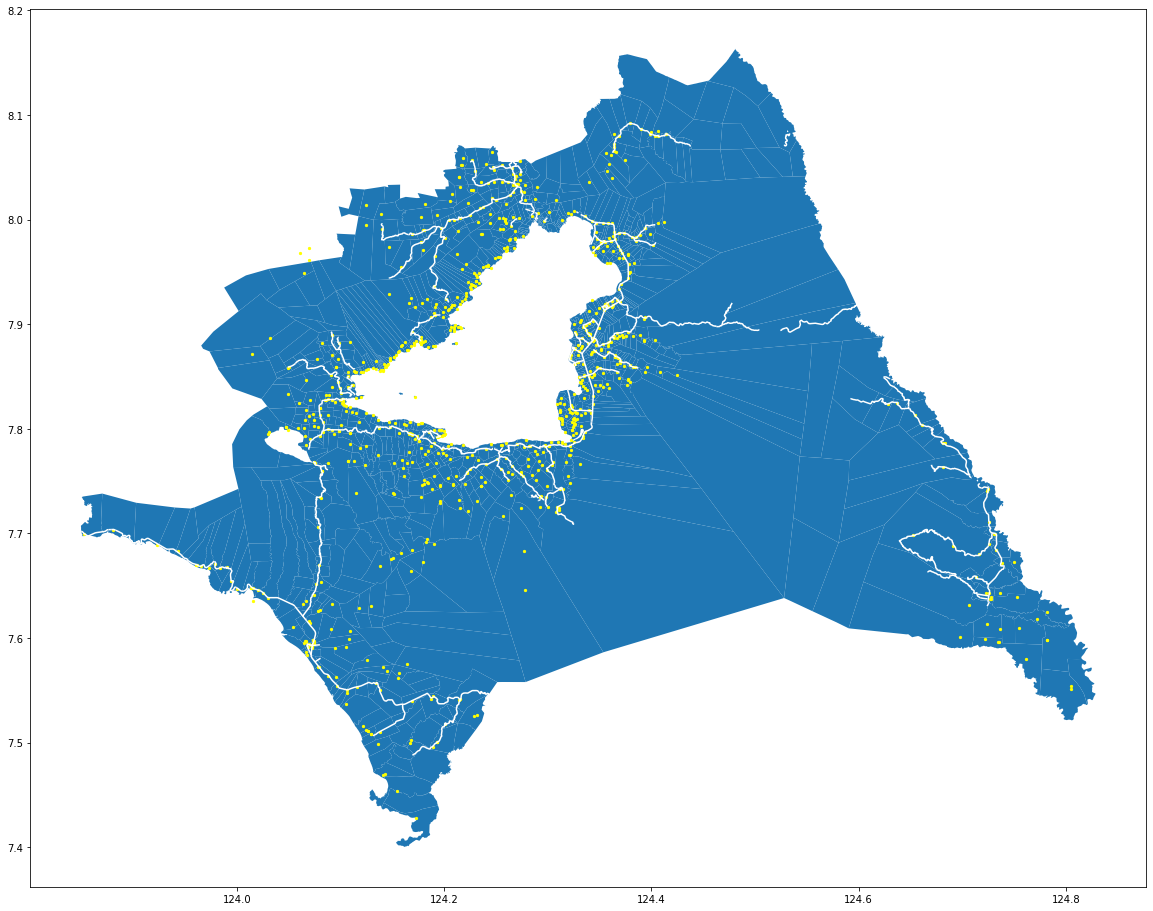

In [3]:
base = brgys_geodata.plot(figsize=(20,20))
roads_geodata.plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)